# Banknote Authentication using TensorFlow

### Aim

Detect forged banknotes based on data (extracted from images) from genuine and forged banknote-like specimens.

### Dataset

[Bank Authentication Dataset from the UCI Repository](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

### Information about the dataset

1. **Image.Var:** Variance of Wavelet Transformed image (WTI) (continuous) 
2. **Image.Skew:** Skewness of WTI (continuous) 
3. **Image.Curt:** Curtosis of WTI (continuous) 
4. **Entropy:** Entropy of image (continuous) 
5. **Class:** Whether or not the banknote was authentic (integer)

## Imports

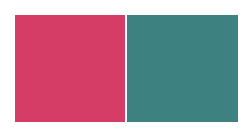

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set palette
crimson_green = sns.diverging_palette(1, 190, sep=80, n=2)
sns.palplot(crimson_green)

In [2]:
# Import dataset
bank_notes = pd.read_csv('input/bank_note_data.csv')

In [3]:
bank_notes.shape

(1372, 5)

In [4]:
bank_notes.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
bank_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
Image.Var     1372 non-null float64
Image.Skew    1372 non-null float64
Image.Curt    1372 non-null float64
Entropy       1372 non-null float64
Class         1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [6]:
bank_notes.describe()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


## Exploratory data analysis

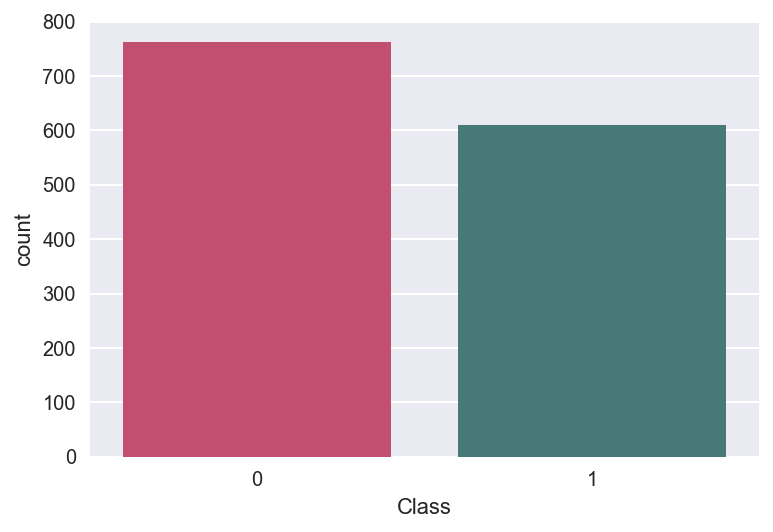

In [7]:
sns.countplot(x='Class', data=bank_notes, palette=crimson_green)
plt.savefig('countplot', dpi=300)

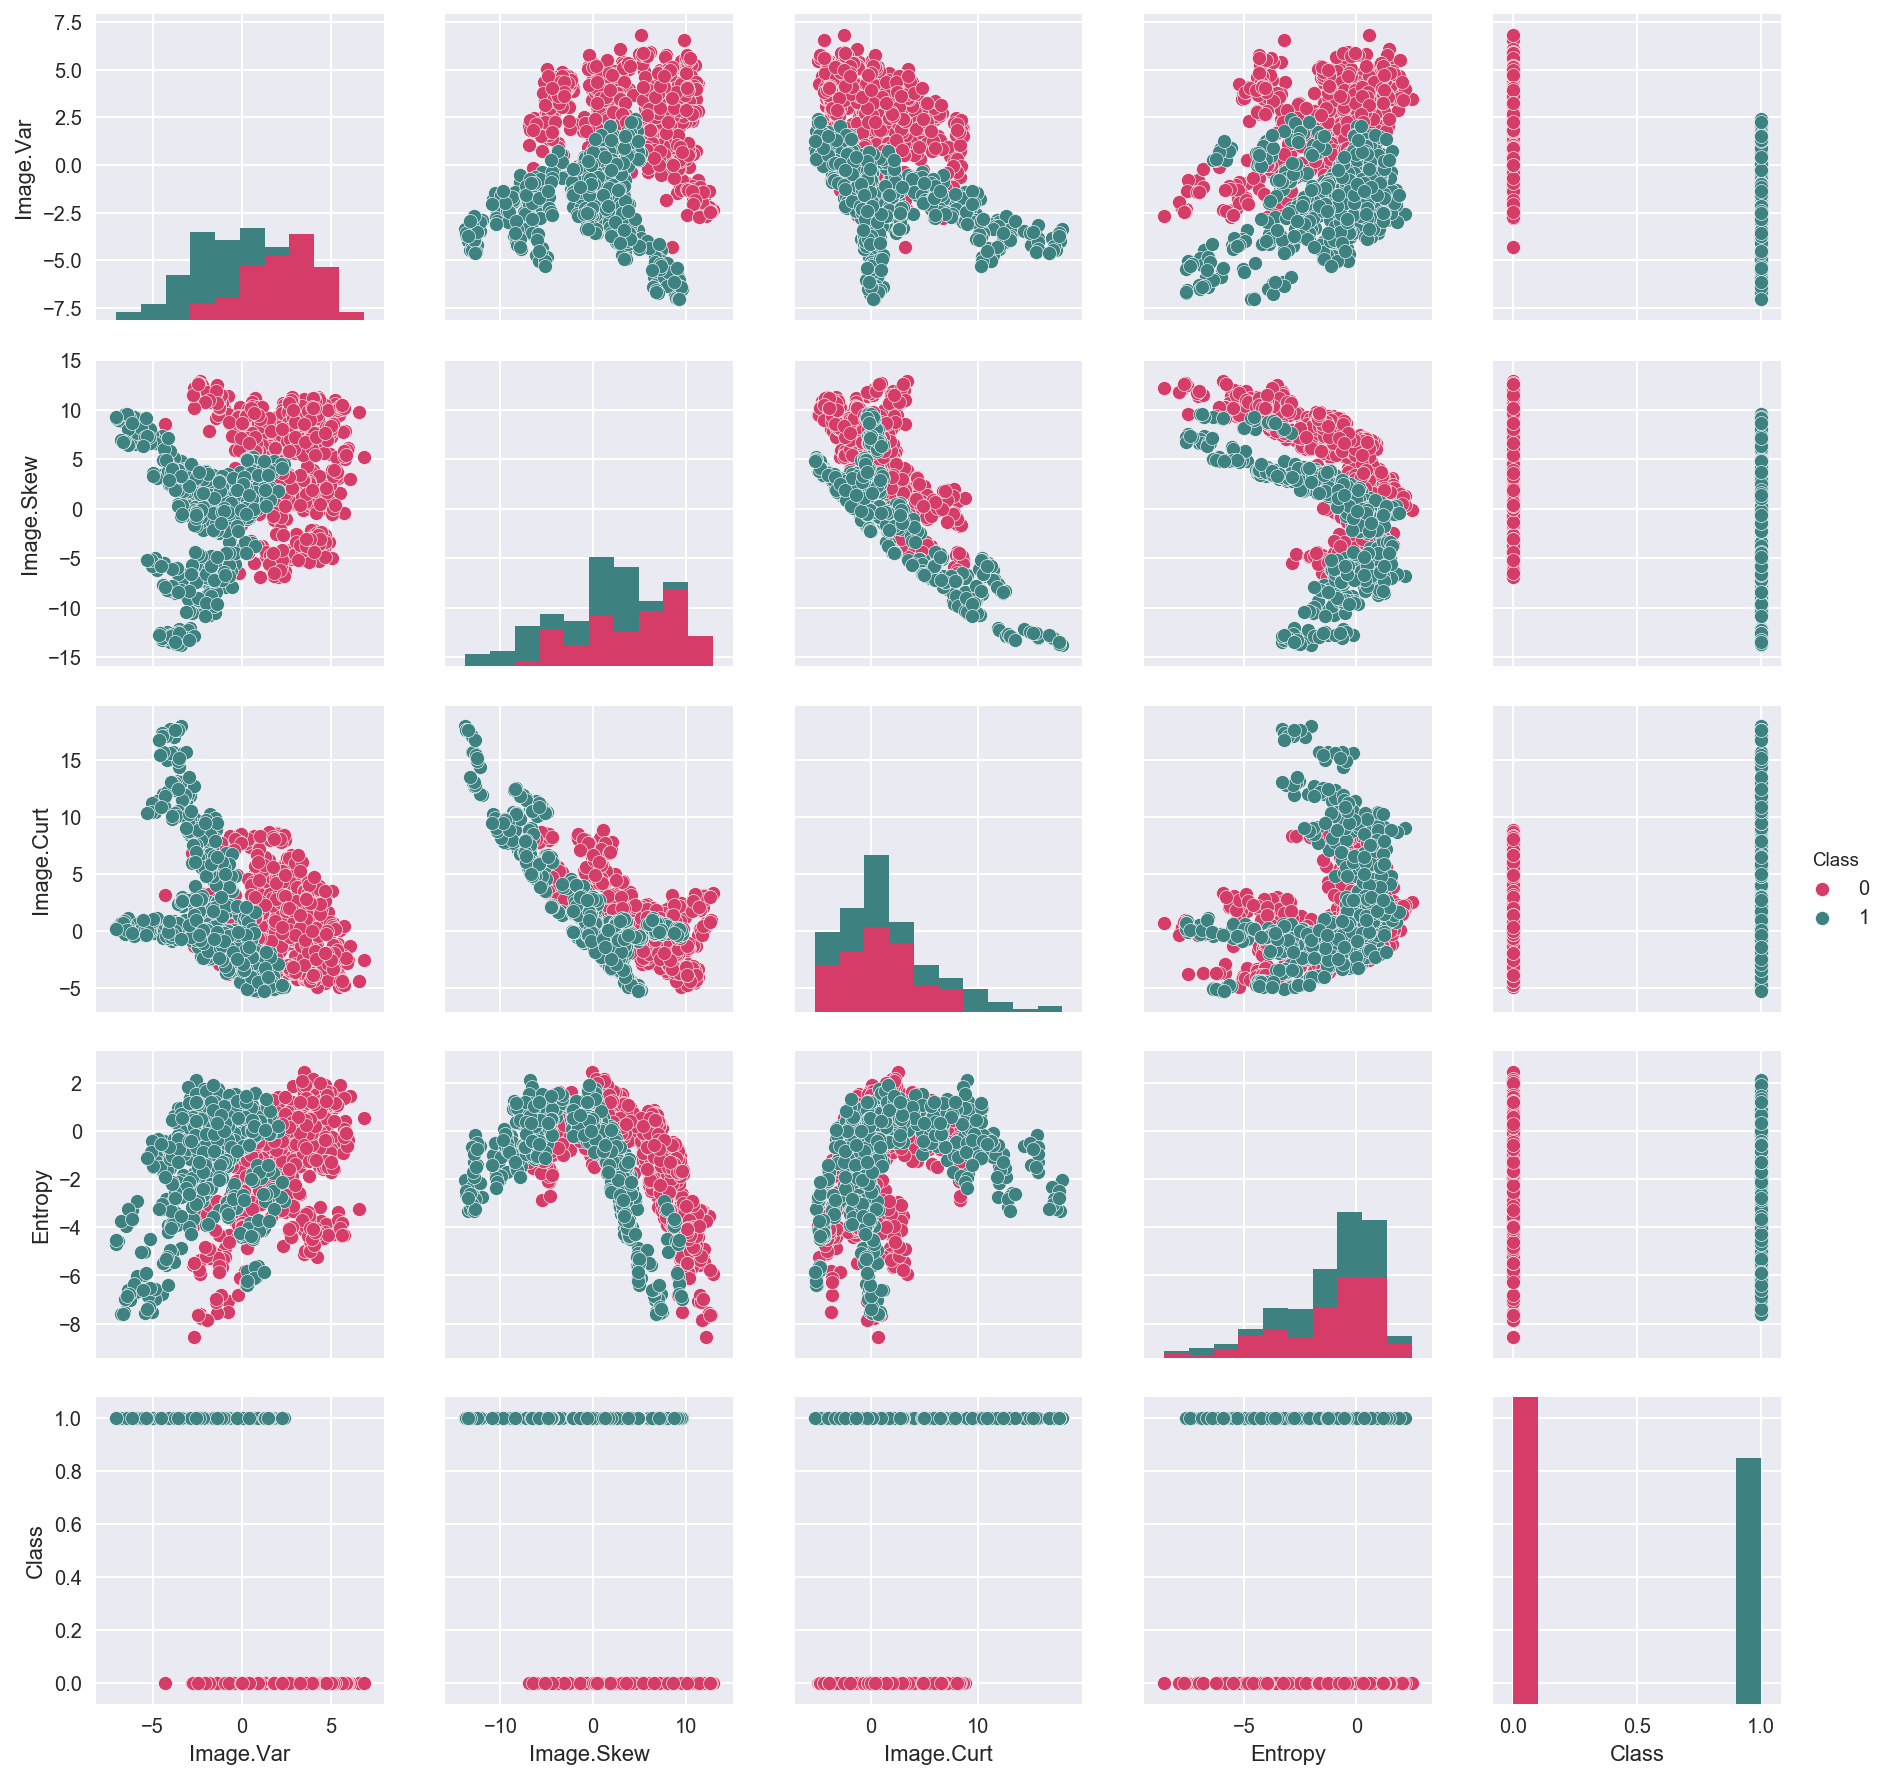

In [8]:
sns.pairplot(data=bank_notes, hue='Class', palette=crimson_green)
plt.savefig('pairplot', dpi=300)

## Standardization

In [9]:
# Create a new dataframe with 'Class' removed
bank_notes_without_class = bank_notes.drop('Class', axis=1)

# Fit scaler
scaler = StandardScaler()
scaler.fit(bank_notes_without_class)

# Store scaled features as a separate dataframe
scaled_features = pd.DataFrame(data=scaler.transform(bank_notes_without_class), columns=bank_notes_without_class.columns)
scaled_features.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587


## Train-test split

First, separate authentic and forged classes.

In [10]:
# Rename 'Class' attribute to 'Authentic'
bank_notes = bank_notes.rename(columns={'Class': 'Authentic'})

# Create 'Forged' attribute
bank_notes.loc[bank_notes['Authentic'] == 0, 'Forged'] = 1
bank_notes.loc[bank_notes['Authentic'] == 1, 'Forged'] = 0

bank_notes.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Authentic,Forged
0,3.62160,8.6661,-2.8073,-0.44699,0,1.0
1,4.54590,8.1674,-2.4586,-1.46210,0,1.0
2,3.86600,-2.6383,1.9242,0.10645,0,1.0
3,3.45660,9.5228,-4.0112,-3.59440,0,1.0
4,0.32924,-4.4552,4.5718,-0.98880,0,1.0


Create **X** (Pandas Dataframe) and **y** (Pandas Series) and transform them into Numpy arrays.

In [11]:
X = scaled_features
y = bank_notes[['Authentic', 'Forged']]

X = X.as_matrix()
y = y.as_matrix()

Split data into training and test set, with test size being **20%**.

In [12]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shapes
print("TRAINING SET SHAPES")
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print()
print("TEST SET SHAPES")
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

TRAINING SET SHAPES
X_train : (1097, 4)
y_train : (1097, 2)

TEST SET SHAPES
X_test : (275, 4)
y_test : (275, 2)


## Parameters

In [13]:
# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 100

# Neural network parameters
n_hidden_1 = 4 # # nodes in first hidden layer
n_hidden_2 = 4 # # nodes in second hidden layer
n_input = 4 # input shape
n_classes = 2 # total classes (authentic / forged)
n_samples = X_train.shape[0]

# Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

## Multilayer model

In [14]:
def multilayer_perceptron(x, weights, biases):
    
    '''
    x : Placeholder for data input
    weights: Dictionary of weights
    biases: Dicitionary of biases
    
    '''
    
    # First hidden layer with ReLU
    # (X * W) + B
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # RELU: ((X * W) + B) -> f(x) = max(0,x)
    layer_1 = tf.nn.relu(layer_1)
    
    # Second hidden layer with ReLU
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out'] + biases['out'])
    return out_layer

## Weights and biases

In [15]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

In [16]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [17]:
# Construct model
preds = multilayer_perceptron(x, weights, biases)

## Cost and optimization

In [18]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=preds))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Initialization of variables

In [43]:
# Initialize variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Train the model

In [83]:
# Launch the session
sess = tf.InteractiveSession()

# Intialize all the variables
sess.run(init)

costs = []

for epoch in range(training_epochs):

    avg_cost = 0.0

    # Number of batches
    total_batch = int(n_samples/batch_size)

    # Loop over all batches
    for batch in range(total_batch):

        # Grab the next batch of training data and labels
        batch_x = X_train[batch*batch_size : (1+batch)*batch_size]
        batch_y = y_train[batch*batch_size : (1+batch)*batch_size]

        # Feed dictionary for optimization / Get loss value
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost += c / total_batch
    
    print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))
    costs.append(avg_cost)
    
print("Model has completed {} epochs of training.".format(training_epochs))

Epoch: 1 cost=1.0476
Epoch: 2 cost=0.6022
Epoch: 3 cost=0.4642
Epoch: 4 cost=0.3986
Epoch: 5 cost=0.3384
Epoch: 6 cost=0.2776
Epoch: 7 cost=0.2144
Epoch: 8 cost=0.1521
Epoch: 9 cost=0.1067
Epoch: 10 cost=0.0769
Epoch: 11 cost=0.0595
Epoch: 12 cost=0.0485
Epoch: 13 cost=0.0408
Epoch: 14 cost=0.0346
Epoch: 15 cost=0.0294
Epoch: 16 cost=0.0255
Epoch: 17 cost=0.0225
Epoch: 18 cost=0.0200
Epoch: 19 cost=0.0180
Epoch: 20 cost=0.0164
Epoch: 21 cost=0.0149
Epoch: 22 cost=0.0137
Epoch: 23 cost=0.0126
Epoch: 24 cost=0.0117
Epoch: 25 cost=0.0108
Epoch: 26 cost=0.0101
Epoch: 27 cost=0.0094
Epoch: 28 cost=0.0088
Epoch: 29 cost=0.0083
Epoch: 30 cost=0.0078
Epoch: 31 cost=0.0074
Epoch: 32 cost=0.0070
Epoch: 33 cost=0.0066
Epoch: 34 cost=0.0062
Epoch: 35 cost=0.0059
Epoch: 36 cost=0.0056
Epoch: 37 cost=0.0054
Epoch: 38 cost=0.0051
Epoch: 39 cost=0.0049
Epoch: 40 cost=0.0047
Epoch: 41 cost=0.0045
Epoch: 42 cost=0.0043
Epoch: 43 cost=0.0041
Epoch: 44 cost=0.0040
Epoch: 45 cost=0.0038
Epoch: 46 cost=0.00

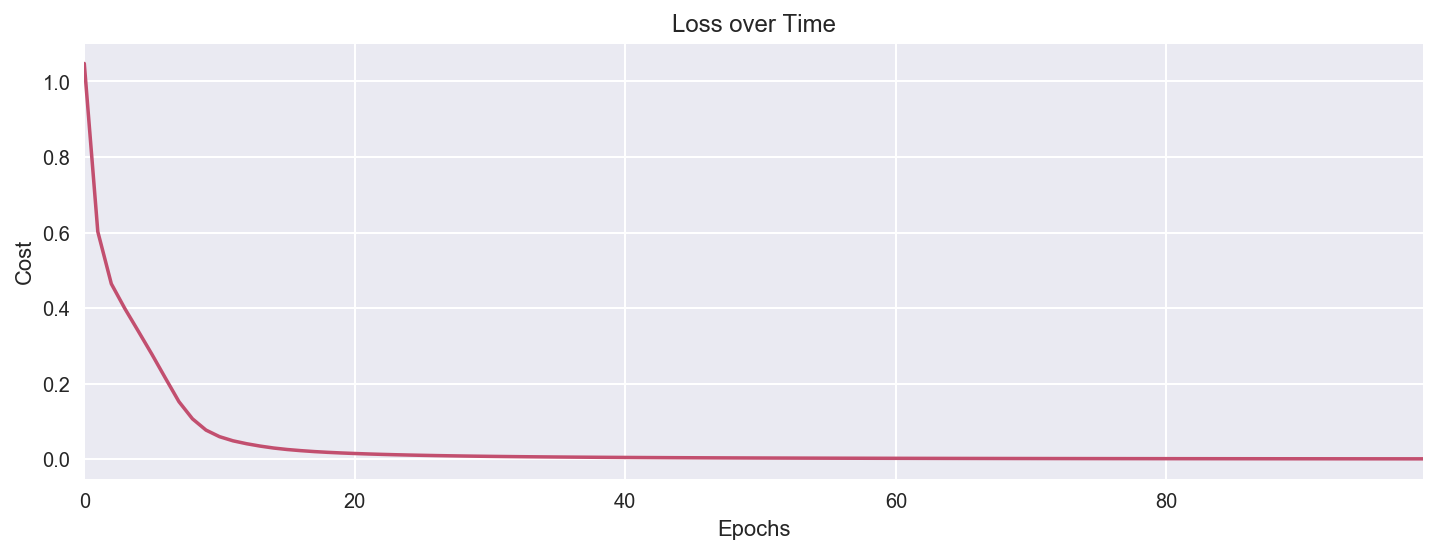

In [84]:
# Visualize loss over time
costs_df = pd.Series(data=costs)
costs_df.plot(figsize=(12, 4), title='Loss over Time', color='#C24F6F')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.savefig('loss', dpi=300)

## Model evaluation

In [64]:
# Test model
correct_predictions = tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1)), tf.float32)
print(correct_predictions[0])

Tensor("strided_slice_2:0", shape=(), dtype=float32)


In [85]:
# Accuracy
accuracy = tf.reduce_mean(correct_predictions)

# Evaluate accuracy and print
print("Accuracy:", accuracy.eval(feed_dict={x: X_test, y: y_test}))

Accuracy: 1.0


## Comparison with Random Forest Classifier

Since our model seems extremely accurate, it's important that we compare it with another model for a reality check.

In [91]:
# Build and train random forest classifier
rfc = RandomForestClassifier(n_estimators=10) 
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [92]:
# Get predictions from random forest classifier
preds_rfc = rfc.predict(X_test)

### Classification report

In [93]:
print(classification_report(y_test, preds_rfc))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       127
          1       0.99      0.99      0.99       148

avg / total       0.99      0.99      0.99       275



### Confusion matrix

In [94]:
# Get only the 'Forged' column values from y_test and preds_rfc
y_test_forged = [item[1] for item in y_test]
preds_rfc_forged = [item[1] for item in preds_rfc]

# Print confusion matrix
print(confusion_matrix(y_test_forged, preds_rfc_forged))

[[125   2]
 [  1 147]]


## Conclusion

Since the random forest classifier achieved a 99% accuracy, we can safely conclude that our neural network really did achieve an accuracy of 100% on the test data. Our dataset was probably just easy to classify. 